In [13]:
%pip install pandas nltk textblob vaderSentiment


Note: you may need to restart the kernel to use updated packages.


### Data Pre processing

In [23]:
import pandas as pd

# Load the data
data = pd.read_csv('/Users/nivethikaa/Documents/GitHub/is434_heritageone/google_reviews.csv')

# Handle missing values in the 'description' column
data['description'] = data['description'].fillna('')
print("Initial Data Sample:")
print(data[['description']].head(), "\n")  # Print initial sample


Initial Data Sample:
                                         description
0  I have invited a 3 friends for the dinner.\nTh...
1  Pleased to see a Mangalorean restaurant finall...
2  Good service.   Fish a bit too spicy and lassi...
3  Nothing quite satisfies your taste buds like a...
4  My uncle called me up, excited to tell me abou... 



In [24]:
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nivethikaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nivethikaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nivethikaa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenization
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(processed_tokens)

# Apply preprocessing
data['cleaned_description'] = data['description'].apply(preprocess_text)
print("Data after Cleaning and Tokenization:")
print(data[['description', 'cleaned_description']].head(), "\n")  # Print cleaned sample


Data after Cleaning and Tokenization:
                                         description  \
0  I have invited a 3 friends for the dinner.\nTh...   
1  Pleased to see a Mangalorean restaurant finall...   
2  Good service.   Fish a bit too spicy and lassi...   
3  Nothing quite satisfies your taste buds like a...   
4  My uncle called me up, excited to tell me abou...   

                                 cleaned_description  
0  invited friend dinner service fantastic food t...  
1  pleased see mangalorean restaurant finally ope...  
2  good service fish bit spicy lassi sweet probab...  
3  nothing quite satisfies taste bud like authent...  
4  uncle called excited tell mangalorean place si...   



#### convert the relative dates (like "a month ago") to actual dates.

In [26]:
from datetime import datetime, timedelta

# Function to convert relative dates to actual dates
def convert_relative_date(relative_date):
    if 'a month ago' in relative_date:
        return datetime.now() - timedelta(days=30)
    elif 'months ago' in relative_date:
        months_ago = int(relative_date.split()[0])
        return datetime.now() - timedelta(days=months_ago * 30)
    elif 'a week ago' in relative_date:
        return datetime.now() - timedelta(weeks=1)
    elif 'weeks ago' in relative_date:
        weeks_ago = int(relative_date.split()[0])
        return datetime.now() - timedelta(weeks=weeks_ago)
    elif 'a day ago' in relative_date:
        return datetime.now() - timedelta(days=1)
    elif 'days ago' in relative_date:
        days_ago = int(relative_date.split()[0])
        return datetime.now() - timedelta(days=days_ago)
    else:
        return None  # Handle other cases as necessary


In [27]:
# Convert date column
data['date'] = data['date'].apply(convert_relative_date)
print("Converted Dates Sample:")
print(data[['date']].head(), "\n")  # Print converted dates sample


Converted Dates Sample:
                        date
0 2024-10-12 00:16:54.055427
1 2024-06-14 00:16:54.055447
2 2024-10-12 00:16:54.055450
3 2024-05-15 00:16:54.055454
4 2024-04-15 00:16:54.055457 



In [28]:
from textblob import TextBlob

# Function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)  # Analyze sentiment
    # Classify sentiment based on polarity
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'


In [29]:
# Apply sentiment analysis
data['sentiment'] = data['cleaned_description'].apply(get_sentiment)
print("Data with Sentiment Analysis Results:")
print(data[['cleaned_description', 'sentiment']].head(), "\n")  # Print sample with sentiment


Data with Sentiment Analysis Results:
                                 cleaned_description sentiment
0  invited friend dinner service fantastic food t...  positive
1  pleased see mangalorean restaurant finally ope...  positive
2  good service fish bit spicy lassi sweet probab...  positive
3  nothing quite satisfies taste bud like authent...  positive
4  uncle called excited tell mangalorean place si...  positive 



In [30]:
# Aggregate sentiment over time
sentiment_over_time = data.groupby(data['date'].dt.to_period('M')).size()

# Check if sentiment_over_time is empty before plotting
if sentiment_over_time.empty:
    print("No sentiment data available for the specified date range.")
else:
    # Print sentiment trends
    print("Sentiment Trend Over Time:")
    print(sentiment_over_time, "\n")


Sentiment Trend Over Time:
date
2023-12     4
2024-01     3
2024-03    10
2024-04    19
2024-05    19
2024-06     9
2024-07     8
2024-08     4
2024-09     4
2024-10     5
Freq: M, dtype: int64 



In [31]:
%pip install wordcloud matplotlib pandas nltk


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
import re

# Load the CSV file
data = pd.read_csv('google_reviews.csv')

# Preprocess ratings to categorize sentiment
def categorize_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating >= 2.0:
        return 'neutral'
    else:
        return 'negative'

# Apply the categorize function to the 'rating' column
data['sentiment'] = data['rating'].apply(categorize_sentiment)

# Define a function to create and display word cloud and fetch reviews
def generate_wordcloud_with_reviews(data, sentiment):
    # Filter data for the specific sentiment
    sentiment_data = data[data['sentiment'] == sentiment]
    
    # Replace NaN values in 'description' column with empty strings
    sentiment_data['description'] = sentiment_data['description'].fillna('')
    
    # Combine all reviews into one text string
    text = ' '.join(sentiment_data['description'].tolist())
    
    # Define a set of stopwords (common words to exclude)
    stopwords = set(STOPWORDS)
    
    # Create a word cloud while excluding stop words
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiments')
    plt.show()
    
    # Get the top words from the word cloud, excluding stop words
    word_list = [word for word in text.split() if word.lower() not in stopwords]
    word_freq = Counter(word_list)
    top_words = [word for word, freq in word_freq.most_common(10)]  # Get the top 10 meaningful words
    
    # Print one-line excerpts from the reviews containing the top words
    print(f"One-line excerpts from reviews containing top words for {sentiment.capitalize()} sentiment:")
    for word in top_words:
        
        # Use regular expression for exact word match
        reviews = sentiment_data[sentiment_data['description'].apply(lambda x: bool(re.search(rf'\b{word}\b', x, re.IGNORECASE)))]['description'].tolist()
        for review in reviews:
            # Print only the first line of each review
            first_line = review.split('.')[0]  # Get the text before the first period (.)
            print(f"- {first_line}")

# Generate word clouds and display one-line review excerpts for each sentiment
generate_wordcloud_with_reviews(data, 'positive')
generate_wordcloud_with_reviews(data, 'negative')
generate_wordcloud_with_reviews(data, 'neutral')


### Using incrementer and decrementer for sentiment analysis

In [32]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

# Load data from the CSV file
df = pd.read_csv('google_reviews.csv')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define the phrasebook for incrementers, decrementers, and inverters
phrasebook = {
    'incrementers': {
        "very": 2, 
        "so": 2, 
        "amazingly": 2, 
        "extremely": 2, 
        "incredibly": 2, 
        "super": 2, 
        "exceptionally": 2
    },
    'decrementers': {
        "a bit": 0.5, 
        "slightly": 0.5, 
        "barely": 0.25, 
        "somewhat": 0.75, 
        "kind of": 0.75, 
        "a little": 0.75
    },
    'inverters': {
        "not good": -1, 
        "not bad": 1, 
        "lack of": -1, 
        "opposite of": -1, 
        "hardly": -1,
        "pathetic": -1,
        "not impressive": -1
    }
}

# Function to extract positive and negative words
def extract_positive_negative_words(text):
    if isinstance(text, str):  # Check if input is a string
        words = word_tokenize(text.lower())
        words = [word for word in words if word.isalnum() and word not in stop_words]
        
        # Placeholder logic for identifying positive and negative words
        positive_words = [word for word in words if len(word) > 3]
        negative_words = [word for word in words if len(word) <= 3]
    else:
        positive_words = []
        negative_words = []
    
    return positive_words, negative_words, len(words)  # Return word count as well

# Function to adjust the score using the phrasebook
def apply_phrasebook(text, base_score):
    score = base_score

    if isinstance(text, str):  # Only process valid strings
        # Apply incrementers (multiply sentiment score)
        for phrase, multiplier in phrasebook['incrementers'].items():
            if re.search(r'\b' + phrase + r'\b', text, re.IGNORECASE):
                score *= multiplier

        # Apply decrementers (reduce sentiment score)
        for phrase, multiplier in phrasebook['decrementers'].items():
            if re.search(r'\b' + phrase + r'\b', text, re.IGNORECASE):
                score *= multiplier

        # Apply inverters (reverse sentiment)
        for phrase, invert_score in phrasebook['inverters'].items():
            if re.search(r'\b' + phrase + r'\b', text, re.IGNORECASE):
                score = -abs(score) if invert_score == -1 else abs(score)

    return score

# Function to calculate normalized sentiment score
def sentiment_score(text):
    base_score = 0
    positive_words, negative_words, word_count = extract_positive_negative_words(text)

    # Apply the basic sentiment score based on word categories
    base_score += len(positive_words) - len(negative_words)

    # Modify sentiment using the phrasebook
    final_score = apply_phrasebook(text, base_score)

    # Normalize the final score by the word count to make it length-agnostic
    if word_count > 0:
        normalized_score = final_score / word_count
    else:
        normalized_score = 0  # Handle case where word count is 0 (empty review)

    return normalized_score

# Handle missing descriptions by replacing NaN with empty strings
df['description'] = df['description'].fillna('')

# Apply sentiment analysis to each review
df['sentiment_score'] = df['description'].apply(sentiment_score)

# Sort the DataFrame by sentiment score in ascending order (lowest to highest)
df_sorted = df.sort_values(by='sentiment_score')

# Save the sorted reviews to a new CSV file
df_sorted.to_csv('google_reviews_normalized_sorted_by_sentiment.csv', index=False)

# Print sorted DataFrame for verification (optional)
print(df_sorted[['user_name', 'description', 'sentiment_score']])


                   user_name  \
37       Clement Mascarenhas   
219               Soumia T S   
205                        A   
73                Marcus Tan   
67        Prasoon Srivastava   
..                       ...   
94          Naveen Kumar P N   
56              Suresh Kumar   
9    Food vloggers Singapore   
174             David Dubier   
46             Prasan Shetty   

                                           description  sentiment_score  
37   To begin with there is no taste of  “authentic...        -1.604396  
219                                   Pathetic service        -1.000000  
205                                                 Ok        -1.000000  
73   While the food is reasonably priced and taste ...        -0.793103  
67   Pretty pathetic place in terms of customer ser...        -0.587302  
..                                                 ...              ...  
94   Very good restaurant... Mutton biryani is a mu...         2.545455  
56   For dine in, espec

In [33]:
# Define thresholds for sentiment classification
def classify_sentiment(score):
    if score >= 0.5:
        return 'positive'
    elif score <= -0.5:
        return 'negative'
    else:
        return 'neutral'

# Apply classification
df['sentiment_class'] = df['sentiment_score'].apply(classify_sentiment)

# Display counts for each category
print("Positive reviews:", (df['sentiment_class'] == 'positive').sum())
print("Negative reviews:", (df['sentiment_class'] == 'negative').sum())
print("Neutral reviews:", (df['sentiment_class'] == 'neutral').sum())

# Print a sample of reviews in each sentiment category for analysis
print("\nSample Negative Reviews:\n", df[df['sentiment_class'] == 'negative'][['description', 'sentiment_score']].head())
print("\nSample Neutral Reviews:\n", df[df['sentiment_class'] == 'neutral'][['description', 'sentiment_score']].head())
print("\nSample Positive Reviews:\n", df[df['sentiment_class'] == 'positive'][['description', 'sentiment_score']].head())


Positive reviews: 211
Negative reviews: 5
Neutral reviews: 279

Sample Negative Reviews:
                                            description  sentiment_score
37   To begin with there is no taste of  “authentic...        -1.604396
67   Pretty pathetic place in terms of customer ser...        -0.587302
73   While the food is reasonably priced and taste ...        -0.793103
205                                                 Ok        -1.000000
219                                   Pathetic service        -1.000000

Sample Neutral Reviews:
                                            description  sentiment_score
2    Good service.   Fish a bit too spicy and lassi...         0.409091
49   Nice n cozy place to have drinks n enjoy game....         0.464286
80   The food is quite nice, especially the biryani...         0.388889
85   Pros : Food was good\nOrder A la carte\nBooze ...        -0.490196
100  Wonderful restaurant to enjoy food with family...         0.409091

Sample Positive Rev

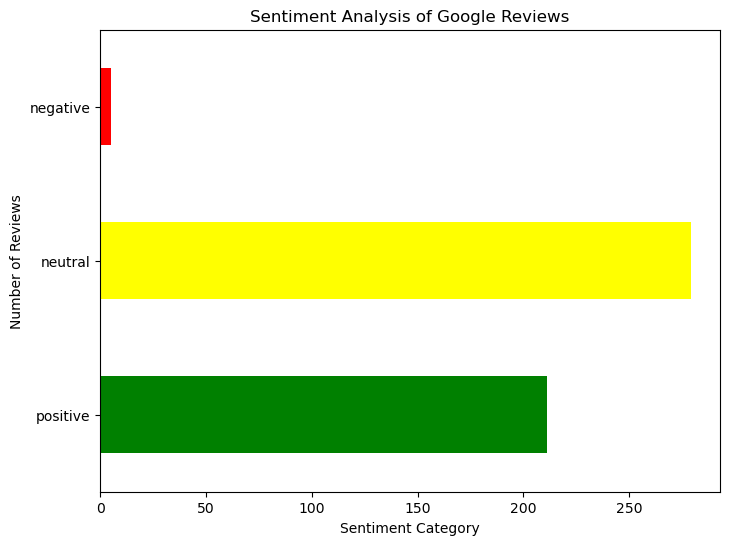

In [35]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment category
sentiment_counts = df['sentiment_class'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
colors = ['green', 'yellow', 'red']
sentiment_counts.reindex(['positive', 'neutral', 'negative']).plot(kind='barh', color=colors)

# Adding labels and title
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Analysis of Google Reviews')

# Display the plot
plt.show()


### Misc code to test word cloud

Positive Review Word Cloud:


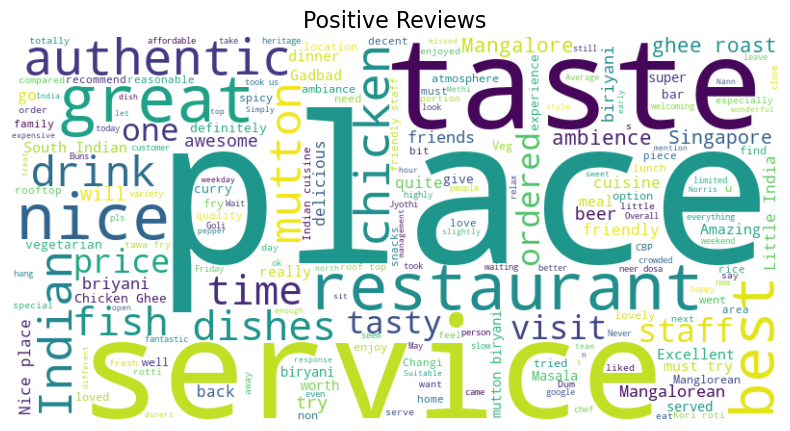

Negative Review Word Cloud:


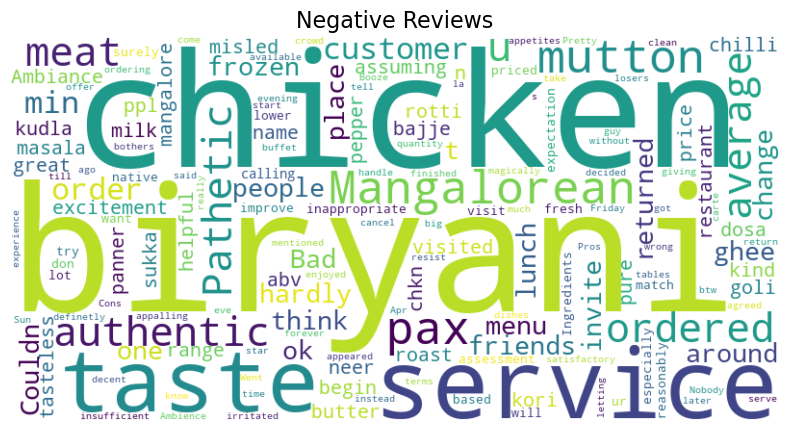

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Function to categorize reviews into positive, negative, and neutral
def categorize_review(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply categorization based on sentiment score
df_sorted['category'] = df_sorted['sentiment_score'].apply(categorize_review)

# Create a function to generate a word cloud from the text of reviews
def generate_wordcloud(text, title):
    # Add custom stopwords
    custom_stopwords = set(STOPWORDS).union({"good", "food"})
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Separate reviews into positive, negative, and neutral categories
positive_reviews = df_sorted[df_sorted['category'] == 'positive']['description'].astype(str)
negative_reviews = df_sorted[df_sorted['category'] == 'negative']['description'].astype(str)

# Generate and plot word clouds for each category
print("Positive Review Word Cloud:")
generate_wordcloud(positive_reviews, 'Positive Reviews')

print("Negative Review Word Cloud:")
generate_wordcloud(negative_reviews, 'Negative Reviews')
